<a href="https://colab.research.google.com/github/zhizhuoli1/Machine-Learning-Operations-Platforms---Stroke-Prediction/blob/main/Azure%20-%20Stroke%20Prediction_ZhizhuoLi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up Azure Workspace for Dirty Data

In [1]:
import numpy as np
import pandas as pd
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

from azureml.core import Dataset, Workspace, Experiment
ws = Workspace.from_config()
exp = Experiment(workspace=ws, name="stroke_prediction")
run = exp.start_logging() 
subscription_id = 'edd414a3-1074-4950-b852-7c3fc44a2b0d'
resource_group = 'docs-aml'
workspace_name = 'docs_ws'
workspace = Workspace(subscription_id, resource_group, workspace_name)
dataset = Dataset.get_by_name(workspace, name='stroke_clean').to_pandas_dataframe()

dataset['bmi'] = dataset['bmi'].apply(lambda x: float(x) if x != 'N/A' else np.nan)
dt = dataset.dropna()
dt = dt.drop(['id'], axis = 1)
data = pd.get_dummies(dt, columns=['gender', 'ever_married','work_type', 'Residence_type','smoking_status'], drop_first=True, dtype=np.int64)
y = data['stroke']
X = data.drop(columns=['stroke'])
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,True,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,True,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,True,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,True,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,True,Self-employed,Rural,174.12,24.0,never smoked,1


# Models
## Logisitc Regression

In [2]:
#split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [3]:
log_model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = np.logspace(0, 5, num=10)
grid = dict(solver=solvers,penalty=penalty,C=c_values)

In [4]:
randomizedsearch = RandomizedSearchCV(log_model, grid)
best_log = randomizedsearch.fit(X_train, y_train)
best_log_model = best_log.best_estimator_
print("The Best Logistics Model is as following: \n", best_log_model)

The Best Logistics Model is as following: 
 LogisticRegression(C=27825.59402207126)


In [5]:
def model_metrics(X_test, y_test, model):
    y_pred = model.predict(X_test)
    accuracy_score = model.score(X_test, y_test)
    f1_score = metrics.f1_score(y_test, y_pred)
    roc_auc_score = metrics.roc_auc_score(y_test, y_pred)
    return accuracy_score, f1_score, roc_auc_score

In [6]:
def roc_curve(X, y, model):
    import matplotlib.pyplot as plt

    prob = model.predict_proba(X)
    pred = prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.1f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([-0.01, 1.01], [-0.01, 1.01],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    

In [7]:
def classifcation_reports(X_test, X_train, y_test, y_train, model):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    return('Classification report for train data is : \n',metrics.classification_report(y_train, y_train_pred)),('Classification report for test data is : \n',metrics.classification_report(y_test, y_test_pred))

In [8]:
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [9]:
def plot_classification_report(X_test, y_test, model, figsize=(5, 5), ax=None):
    y_pred =best_log_model.predict(X_test)
    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_test))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_test, y_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=True, 
                cmap="YlGnBu",
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax,
                linewidths=.5)
    

In [10]:
accuracy_score,f1_score, roc_curve_score = model_metrics(X_test, y_test,best_log_model)
run.log("accuracy_log", accuracy_score)
run.log("f1_score_log", f1_score)
run.log("roc_curve_score_log", roc_curve_score)

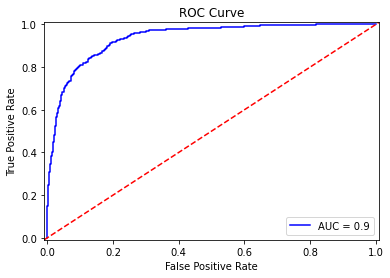

In [11]:
best_log_roc = roc_curve(X_test,y_test,best_log_model)
run.log_image("log_roc_curve", plot=plt)

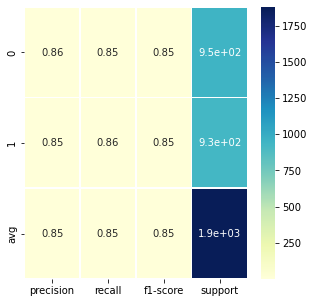

In [12]:
classfication_report = plot_classification_report(X_test, y_test,best_log_model)
run.log_image("classifcation report", plot=plt)

In [13]:
import joblib
model_name = "best_log_model.pkl"
filename = "outputs/" + model_name
joblib.dump(value=best_log_model, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
#run.complete()

## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=8, n_jobs = -1)
# Fit the random search model
best_rf = rf_random.fit(X_train, y_train)
best_rf_model = best_rf.best_estimator_
print("The Best Random Forest Model is as following: \n", best_rf.best_estimator_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
accuracy_score,f1_score, roc_curve_score = model_metrics(X_test, y_test,best_rf_model)
run.log("accuracy_log", accuracy_score)
run.log("f1_score_log", f1_score)
run.log("roc_curve_score_log", roc_curve_score)

In [ ]:
best_log_roc = roc_curve(X_test,y_test,best_rf_model)
run.log_image("rf_roc_curve", plot=plt)

In [ ]:
classfication_report = plot_classification_report(X_test, y_test,best_rf_model)
run.log_image("classifcation report", plot=plt)

In [ ]:
import joblib
model_name2 = "best_rf_model.pkl"
filename2 = "outputs/" + model_name2
joblib.dump(value=best_rf_model, filename=filename2)
run.upload_file(name=model_name2, path_or_stream=filename2)
run.complete()